In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import json
from collections import Counter

%matplotlib inline

In [5]:
# Specify the IDseq project and sample IDs as input for idseq-bench

PROJECT = '593'
VERSION = '3.13'

SAMPLE_DICT = {
    '27908':'HRC_100',
    '27907':'HRC_099',
    '27906':'HRC_095',
    '27905':'HRC_090',
    '27904':'HRC_085',
    '27903':'HRC_080',
    '27902':'HRC_075',
    '27901':'HRC_070',
    '27900':'HRC_065',
    '27899':'HRC_060',
    '27898':'HRC_055',
    '27897':'HRC_050',
    '27896':'HRC_045',
    '27895':'HRC_040',
    '27894':'HRC_035',
    '27893':'HRC_030',
    '27892':'HRC_025'    
}

### Calculate IDseq NT and NR recall

In [6]:
# Loop through all the samples and determine the recall via idseq-bench-score tool

results = {}
for sample_id in SAMPLE_DICT.keys():
    
    sample_name = SAMPLE_DICT[sample_id]
    print(sample_name)
    
    results[sample_name] = {}
    
    # run idseq-bench-score for this sample
    bench_result = subprocess.check_output("idseq-bench-score "+ PROJECT + " " + sample_id + " " + VERSION, shell=True)
    d = json.loads(''.join(bench_result.decode('utf-8').split('\n')[6:]))
    
    try:
        # get the Rhinovirus C (species and genus) recall values from idseq-bench-score json
        results[sample_name]['NTspecies'] = d['per_rank']['species']['NT']['463676']['recall_per_read']['count']
        results[sample_name]['NTgenus'] = d['per_rank']['genus']['NT']['12059']['recall_per_read']['count']
        results[sample_name]['NRspecies'] = d['per_rank']['species']['NR']['463676']['recall_per_read']['count']
        results[sample_name]['NRgenus'] = d['per_rank']['genus']['NR']['12059']['recall_per_read']['count']
    except:
        # if the sample does not have any reads mapping to Rhinovirus C, the metrics will not
        # appear in the json result; skip these samples
        print("failed to gather metrics for sample: " + sample_name)
        
        

HRC_100
HRC_099
HRC_095
HRC_090
HRC_085
HRC_080
HRC_075
HRC_070
failed to gather metrics for sample: HRC_070
HRC_065
failed to gather metrics for sample: HRC_065
HRC_060
failed to gather metrics for sample: HRC_060
HRC_055
failed to gather metrics for sample: HRC_055
HRC_050
failed to gather metrics for sample: HRC_050
HRC_045
failed to gather metrics for sample: HRC_045
HRC_040
failed to gather metrics for sample: HRC_040
HRC_035
failed to gather metrics for sample: HRC_035
HRC_030
failed to gather metrics for sample: HRC_030
HRC_025
failed to gather metrics for sample: HRC_025


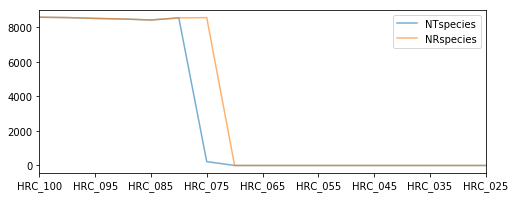

In [7]:
df = pd.DataFrame(results).transpose()
df.fillna(0, inplace=True)
df[['NTspecies','NRspecies']].plot(figsize=(8,3), alpha=.6)

### Read Kraken2 results

In [8]:
kraken_results_folder = './data/kraken2/hrc_experiment/'

kraken_dict = {}

for sample_id in SAMPLE_DICT.keys():
    
    sample_name = SAMPLE_DICT[sample_id]
    kraken_dict[sample_name] = {}
    
    print(sample_name)
    kraken_res = kraken_results_folder + sample_name + '.kraken2.out'
    this_result = pd.read_csv(kraken_res, sep = '\t', header=None)
    
    kraken_dict[sample_name]['classified'] = 2*(Counter(this_result[0])['C'])
    
    correct = 2*Counter(this_result[2])[463676]
    false_positives = (kraken_dict[sample_name]['classified'] - correct) #/ kraken_dict[sample_name]['classified']
    
    kraken_dict[sample_name]['recall'] = 2* (Counter(this_result[2])[463676] / kraken_dict[sample_name]['classified'])
    kraken_dict[sample_name]['true_positive'] = 2*(Counter(this_result[2])[463676])
    kraken_dict[sample_name]['false_positives'] = (false_positives)
    

HRC_100
HRC_099
HRC_095
HRC_090
HRC_085
HRC_080
HRC_075
HRC_070
HRC_065
HRC_060
HRC_055
HRC_050
HRC_045
HRC_040
HRC_035
HRC_030
HRC_025


In [9]:
df2 = pd.concat([df,pd.DataFrame(kraken_dict).transpose()],axis=1)
df2.head()

,NRgenus,NRspecies,NTgenus,NTspecies,classified,false_positives,recall,true_positive
HRC_100,8582.0,8582.0,8582.0,8582.0,10000.0,36.0,0.996400,9964.0
HRC_099,8562.0,8562.0,8562.0,8562.0,10000.0,50.0,0.995000,9950.0
HRC_095,8514.0,8514.0,8514.0,8514.0,9990.0,580.0,0.941942,9410.0
HRC_090,8480.0,8480.0,8480.0,8480.0,9036.0,4278.0,0.526560,4758.0
HRC_085,8422.0,8422.0,8422.0,8422.0,4708.0,3530.0,0.250212,1178.0


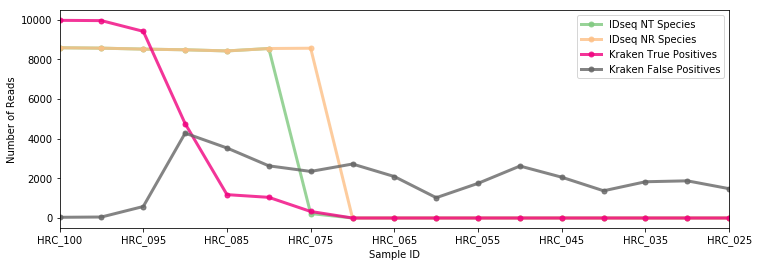

In [10]:

df2.columns = ['IDseq NR Genus', 'IDseq NR Species', 'IDseq NT Genus', 'IDseq NT Species',
               'Kraken Total Classified','Kraken False Positives','Kraken Recall','Kraken True Positives']
df2[['IDseq NT Species','IDseq NR Species','Kraken True Positives','Kraken False Positives']].plot(style='.-', lw = 3, ms = 10,figsize=(12,4), alpha=.8, cmap='Accent')#color=['#068977','green','darkblue','orange'])
plt.xlabel('Sample ID')
plt.ylabel('Number of Reads')
plt.savefig('../Figures/Figure 4.pdf')

/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/katrina.kalantar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

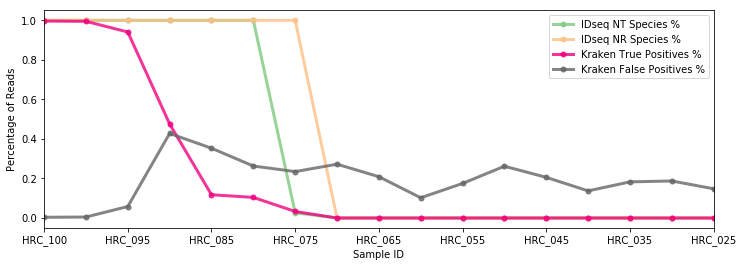

In [46]:

df2.columns = ['IDseq NR Genus', 'IDseq NR Species', 'IDseq NT Genus', 'IDseq NT Species',
               'Kraken Total Classified','Kraken False Positives','Kraken Recall','Kraken True Positives']
percentage_scaled_df = df2[['IDseq NT Species','IDseq NR Species','Kraken True Positives','Kraken False Positives']]

# passed-filters (PF) values from IDseq pipeline QC steps
pf_values = [8582,8562,8514,8480,8422,8544,8558,8504,8492,8496,8450,8430,8458,8466,8466,8478,8466]

percentage_scaled_df['IDseq NT Species %'] = [list(df2['IDseq NT Species'])[i] / pf_values[i] for i in range(len(pf_values))]
percentage_scaled_df['IDseq NR Species %'] = [list(df2['IDseq NR Species'])[i] / pf_values[i] for i in range(len(pf_values))]
percentage_scaled_df['Kraken True Positives %'] = [list(df2['Kraken True Positives'])[i] / 10000 for i in range(len(pf_values))]
percentage_scaled_df['Kraken False Positives %'] = [list(df2['Kraken False Positives'])[i] / 10000 for i in range(len(pf_values))]


percentage_scaled_df = percentage_scaled_df[['IDseq NT Species %', 'IDseq NR Species %', 'Kraken True Positives %', 'Kraken False Positives %']]

percentage_scaled_df.plot(style='.-', lw = 3, ms = 10,figsize=(12,4), alpha=.8, cmap='Accent')#color=['#068977','green','darkblue','orange'])
plt.xlabel('Sample ID')
plt.ylabel('Percentage of Reads')
plt.savefig('../Figures/Figure4_v3.pdf')

In [148]:
df2.head(10)

,IDseq NR Genus,IDseq NR Species,IDseq NT Genus,IDseq NT Species,Kraken Total Classified,Kraken False Positives,Kraken Recall,Kraken True Positives
HRC_100,8582.0,8582.0,8582.0,8582.0,10000.0,36.0,0.996400,9964.0
HRC_099,8562.0,8562.0,8562.0,8562.0,10000.0,50.0,0.995000,9950.0
HRC_095,8514.0,8514.0,8514.0,8514.0,9990.0,580.0,0.941942,9410.0
HRC_090,8480.0,8480.0,8480.0,8480.0,9036.0,4278.0,0.526560,4758.0
HRC_085,8422.0,8422.0,8422.0,8422.0,4708.0,3530.0,0.250212,1178.0
HRC_080,8544.0,8544.0,8544.0,8544.0,3672.0,2630.0,0.283769,1042.0
HRC_075,8558.0,8558.0,291.0,225.0,2678.0,2348.0,0.123226,330.0
HRC_070,0.0,0.0,0.0,0.0,2722.0,2722.0,0.000000,0.0
HRC_065,0.0,0.0,0.0,0.0,2090.0,2090.0,0.000000,0.0
HRC_060,0.0,0.0,0.0,0.0,1024.0,1024.0,0.000000,0.0
